# Running GPT-2 Locally

In [1]:
import torch
import xlab

VOCAB_SIZE = 50257

When loading pretrained models in the course, we will be using the [transformers](https://huggingface.co/docs/transformers/en/index) library developed by Hugging Face. This library abstracts away the complexity of running pretrained language models into a single API. In the cell below, you will be loading the [smallest version of GPT-2](https://huggingface.co/openai-community/gpt2) with 124 million parameters. If you are interested, you can also try out [GPT-2 Medium](https://huggingface.co/openai-community/gpt2-medium) (335 million parameters), [GPT-2 Large](https://huggingface.co/openai-community/gpt2-large) (774 million parameters), and [GPT-2 XL](https://huggingface.co/openai-community/gpt2-xl) (1.5 billion parameters).

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

## Tokenize Text

To input a sequence of text to GPT-2, we first have to decide how we would like to convert the text to numbers so we can feed it to the model. Typically, how this is done is we convert a string of text to a string of tokens, each of which will be assigned a number which can be embedded into a vector. To do this, we have a few options:

1. We can assign each character it's own number
2. We can assign each word or special character it's own number
3. We can assign common sequences of characters their own number

Typically option #3 is most popular and the high-level approach taken in the GPT-2 paper. This approach has the advantage of having a smaller total number of tokens while still capturing some of the underlying structure of natural language. Specifically, the author's use a modified version of BPE (byte pair encoding) proposed [here](https://arxiv.org/pdf/1508.07909). If you are interested, more implementation details of the tokenizer can be found in the [GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). 

Time to try out the GPT-2 tokenizer! Run the cell below see the tokenizer assign the string into a sequence of numbers:

In [3]:
text = "Barack Obama taught constitutional law at the University of"
encoded_input = tokenizer(text, return_tensors='pt')
print(encoded_input['input_ids'])

tensor([[10374,   441,  2486,  7817,  9758,  1099,   379,   262,  2059,   286]])


Let's take a look at what each of these numbers represent:

In [4]:
for token_id in encoded_input['input_ids'][0]:
    print(f'{token_id.item()}\t --> \t"{tokenizer.decode(token_id)}"')

10374	 --> 	"Bar"
441	 --> 	"ack"
2486	 --> 	" Obama"
7817	 --> 	" taught"
9758	 --> 	" constitutional"
1099	 --> 	" law"
379	 --> 	" at"
262	 --> 	" the"
2059	 --> 	" University"
286	 --> 	" of"


We can also decode the entire sequence at once. This will be helpful to remember for later!

In [5]:
tokenizer.decode(encoded_input['input_ids'][0])

'Barack Obama taught constitutional law at the University of'

### Task #1

For a given input of text, return a list of tokens in plain text. For example for the input "Hello there gpt-2!", the function should return ['Hello', ' there', ' g', 'pt', '-', '2', '!']. Note that this is very different than just splitting up the text into random chunks or where there are spaces! Tokenizers are designed to create groupings of characters that are often found together or that are significant in the structure of language. You are encouraged to play around with different examples and observe how smart the tokenizer can be!

In [6]:
# estimated time to complete: ~3 minutes
def plain_text_tokens(prefix):
    """Tokenizes a text prefix into individual token strings.
    
    Args:
        prefix (str): The input text string to be tokenized.
        
    Returns:
        list[str]: A list of individual tokens as strings. Each token represents
            how the tokenizer splits the input text.
            
    Example:
        >>> plain_text_tokens("Hello there gpt-2!")
        ['Hello', ' there', ' g', 'pt', '-', '2', '!']
    """
    rv = []
    ######## YOUR CODE HERE ########
    encoded_input = tokenizer(prefix, return_tensors='pt')
    for i in encoded_input['input_ids'][0]:
        rv.append(tokenizer.decode(i))
    return rv

# test out your implementation on different inputs to get a sense of how the tokenizer works!
print(plain_text_tokens("Hello there gpt-2!"))
print(plain_text_tokens("https://xrisk.uchicago.edu/fellowship/"))

['Hello', ' there', ' g', 'pt', '-', '2', '!']
['https', '://', 'x', 'risk', '.', 'uch', 'icago', '.', 'edu', '/', 'fell', 'owship', '/']


In [7]:
xlab.tests.gpt2.task1(plain_text_tokens)

============================= test session starts ==============================
collected 19 items / 13 deselected / 6 selected

PASSED [ 16%]ts/gpt2.py::test_function_runs_without_crashing 
PASSED [ 33%]ts/gpt2.py::test_tokenization_cases[Hello there gpt-2-expected_output0-basic text with hyphen] 
PASSED [ 50%]ts/gpt2.py::test_tokenization_cases[??!hello--*- world#$-expected_output1-special characters and symbols] 
PASSED [ 66%]ts/gpt2.py::test_tokenization_cases[https://xrisk.uchicago.edu/fellowship/-expected_output2-URL with dots and slashes] 
PASSED [ 83%]ts/gpt2.py::test_tokenization_cases[-expected_output3-empty string] 
PASSED [100%]ts/gpt2.py::test_tokenization_cases[.,.,.,.,.,.,.,-expected_output4-repeated punctuation] 

======================= 6 passed, 13 deselected in 0.02s =======================
✅ All checks passed!


Back to our model. We will tokenize our text into numbers to feed into the model. When the model is done predicting text, we can untokenize the results to see if what the model is saying makes sense.

Below is some code for the one full pass through the model with the prefix "The great scientist Albert Einstein"

Take a look at the shape of the output.

In [8]:
prefix = "Barack Obama taught constitutional law at the University of"
encoded_input = tokenizer(prefix, return_tensors='pt')
output = model(**encoded_input)
logits = output.logits
logits.shape

torch.Size([1, 10, 50257])

Let's take another look at the logit values. Note that the values span a huge positive and negative range. Normally, both in training and in inference, we apply a "softmax" function to the data to bring all values between 0 and 1. We interpret these values as the probability that the model assigns each token to be next in a sequence of text. For now however, we ignore this detail.

In [9]:
max(logits.view(-1)), min(logits.view(-1))

(tensor(-26.1977, grad_fn=<UnbindBackward0>),
 tensor(-285.3222, grad_fn=<UnbindBackward0>))

In [10]:
encoded_input['input_ids']

tensor([[10374,   441,  2486,  7817,  9758,  1099,   379,   262,  2059,   286]])

What is going on here?

`torch.Size([1, 10, 50257])` tells us that logits is a 3 dimensional array (i.e., it is `1*4*50257`). The first dimension represents the batch size and because there is only one batch, we can ignore it for now. The next dimension is the sequence length. Note that:

```python
>>> encoded_input['input_ids']
tensor([[10374,   441,  2486,  7817,  9758,  1099,   379,   262,  2059,   286]])
```

There are 10 tokens when we tokenize "Barack Obama taught constitutional law at the University of" meaning the sequence length is 10. For the final dimension, we have 50257 which represents the model's vocabulary size. Why do we have so much data? Don't we only want the next predicted piece of text?

To understand why this is necessary, you will need to understand what information is included in this tensor. In total, we have 10 vectors of length 50257. Each vector represents a probability distribution for each token in the vocabulary. For example, if the value at 42 is higher, that means that the model is assigning a higher probability to the token at position 42 to be the next in the sequence of text.

This makes sense for our purposes: if we have a probability distribution for the next token in the text, we can sample from it to predict the next token! But why do we have 10 probability distributions in the output. In other words why do we need a probability distribution for each token in the input?

The answer to this question is oddly, that this make it easier to train our model! If we have a piece of text that we are training on from the internet, we can train multiple examples in paralell. For example, if we have the text "Barack Obama taught constitutional law at the University of" here are a several different examples we could choose to train on. 


1. Prefix="Bar" and label="ack"
2. Prefix="Barack" and label=" Obama"
3. Prefix="Barack Obama" and label=" taught"
4. And so on...


The first three vectors in the logits in the code above correspond to the model's predictions for the first three prefixes above. While running inference, we only care about the model's label for the input "Barack Obama taught constitutional law at the University of" so therefore, we only need to extract the final vector from the probability distribution. This makes sense because for our purposes, we aren't interested in efficiently training the model. We are only interested in seeing what the model predicts for the next token.

We can extract this last vector by taking `logits[0][-1]`. Lets see what the model predicts!

In [11]:
text = "Barack Obama taught constitutional law at the University of"

encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
logits = output.logits  # Shape: (batch_size, sequence_length, vocab_size)
token_id = torch.argmax(logits[0][-1])

generated_text = tokenizer.decode([token_id.item()]) 
print(generated_text)

 Chicago


Indeed, Barack Obama taught constitutional law at the University of Chicago ([source](https://www.obamalibrary.gov/obamas/president-barack-obama))! Despite being an early model with limited capabilities, GPT-2 124M knows quite a bit about the world.

In [12]:
def generate_n_tokens(model, tokenizer, n, prompt):
    for i in range(n):

        
        encoded_input = tokenizer(prompt, return_tensors='pt')
        output = model(**encoded_input)
        logits = output.logits
        token_id = torch.argmax(logits[0][-1])
    
        generated_text = tokenizer.decode([token_id.item()])  
        prompt+=generated_text
    return prompt

In [13]:
generated_text = generate_n_tokens(model, tokenizer, 50, text)
print(generated_text)

Barack Obama taught constitutional law at the University of Chicago. He was a founding member of the American Bar Association, and he was a founding member of the American Bar Association's Board of Trustees. He was a founding member of the American Bar Association's Board of Trustees. He was a founding


As you will explore below, running an LLM in practice typically involves sampling tokens by interpreting the model output as a probability distribution. This means that running an LLM should be non-deterministic (i.e., running the same prompt mutiple times should produce different outputs). The function you wrote above however, should not include any sampling, so it should produce the exact same output every time you run it. To test you implementation you can compare your output to the expected output when you run the solution.

In [14]:
expected_output = "Barack Obama taught constitutional law at the University of Chicago. He was a founding member of the American Bar Association, and he was a founding member of the American Bar Association's Board of Trustees. He was a founding member of the American Bar Association's Board of Trustees. He was a founding"
assert generated_text == expected_output

### Why is the model repeating itself?

In the previous cell, we generated text by always choosing the most likely next token (using `torch.argmax`). This deterministic approach has a major drawback: once the model enters a pattern that has high probability, it can get stuck in a loop.

Above you should have observed that "He was a founding member of the American Bar Association's Board of Trustees." repeats continuously before we cut it off.

### Introducing Softmax and Temperature

We have explored the softmax a bit in the defensive [distillation section](https://xlabaisecurity.com/adversarial/defensive-distillation/).

As a review, a traditional softmax is calculated via the following equation. When there are $K$ classes, and $z$ is the pre-softmax output, the equation below gives the probability for class $i$:

$$
q_i = \frac{e^{z_i}}{\sum_{j=0}^{K-1}e^{z_j}}
$$

For our transformer output, we would take the softmax over each channel dimension. That means that for each input token, we would take a softmax for the corresponding output token independently. For inference, we would be sampling from the softmax probabilities for the final output token.

If we want the output of the softmax to be smoother, we can add a constant $T$ which forces the distibution to be more uniform. The value for $T$ is called temperature where a higher $T$ corresponds to more random or surprising outputs. Note that are traditional softmax is the equivalent to the equation below when $T = 1$.

$$
q_i = \frac{e^{z_i / T}}{\sum_{j=0}^{K-1}e^{z_j / T }}
$$

### Task #2: Softmax GPT-2 Outputs

In [41]:
def get_gpt2_probs(logits, temp=1):
    assert len(logits.shape) == 3
    assert logits.shape[-1] == VOCAB_SIZE

    logits_with_temp = logits / temp
    probs = torch.nn.functional.softmax(logits_with_temp, dim=2)
    return probs

In [16]:
xlab.tests.gpt2.task2(get_gpt2_probs)

============================= test session starts ==============================
collected 19 items / 6 deselected / 13 selected

PASSED [  7%]ts/gpt2.py::test_get_gpt2_probs_basic_functionality[1-10-50257-1.0-single batch, standard GPT-2 vocab, temp=1.0] 
PASSED [ 15%]ts/gpt2.py::test_get_gpt2_probs_basic_functionality[4-5-50257-1.0-multi-batch, short sequence, temp=1.0] 
PASSED [ 23%]ts/gpt2.py::test_get_gpt2_probs_basic_functionality[2-20-50257-0.8-multi-batch, longer sequence, temp=0.8] 
PASSED [ 30%]ts/gpt2.py::test_get_gpt2_probs_basic_functionality[1-1-50257-1.5-single token, temp=1.5] 
PASSED [ 38%]ts/gpt2.py::test_get_gpt2_probs_softmax_properties 
PASSED [ 46%]ts/gpt2.py::test_get_gpt2_probs_wrong_dimensions 
PASSED [ 53%]ts/gpt2.py::test_get_gpt2_probs_wrong_vocab_size 
PASSED [ 61%]ts/gpt2.py::test_get_gpt2_probs_extreme_values 
PASSED [ 69%]ts/gpt2.py::test_get_gpt2_probs_temperature_effects[1.0-standard temperature] 
PASSED [ 76%]ts/gpt2.py::test_get_gpt2_probs_temperatur

### Effects of different temperature values:

- **T = 0** (or very close to 0): Completely deterministic, always pick highest probability token (like we did before)
- **T = 1.0**: Standard softmax, use the exact probabilities from the model
- **T > 1.0**: More uniform distribution, increasing randomness and diversity
- **T < 1.0**: More peaked distribution, reducing randomness but still allowing some

Lower temperatures produce more focused, coherent text but risk repetition. Higher temperatures produce more diverse, creative text but risk incoherence.

In the next cell, we'll implement temperature sampling to fix our repetition problem!

In [22]:
def generate_with_temperature(model, tokenizer, prompt, max_length=100, temperature=0.7):
    # Start with the provided prompt
    generated_text = prompt
    
  
    for i in range(max_length):
        encoded_input = tokenizer(prompt, return_tensors='pt')
        output = model(**encoded_input)
        probs = get_gpt2_probs(output.logits, temperature)

        next_token_id = torch.multinomial(probs[0][-1], num_samples=1).item()
    
        generated_text = tokenizer.decode([next_token_id])  
        prompt+=generated_text
    
    return prompt

In [27]:
# Low temperature (more deterministic but not completely)
prompt = "Barack Obama taught constitutional law at the University of"
low_temp_text = generate_with_temperature(
    model, tokenizer, prompt, max_length=40, temperature=0.3
)
print("Temperature = 0.3:")
print("-"*50)
print(low_temp_text + "\n")


# Medium temperature (balanced)
medium_temp_text = generate_with_temperature(
    model, tokenizer, prompt, max_length=40, temperature=0.7
)
print("Temperature = 0.7:")
print("-"*50)
print(medium_temp_text + "\n")


# High temperature (more random)
high_temp_text = generate_with_temperature(
    model, tokenizer, prompt, max_length=40, temperature=1.2
)
print("Temperature = 1.2:")
print("-"*50)
print(high_temp_text)

Temperature = 0.3:
--------------------------------------------------
Barack Obama taught constitutional law at the University of California, Berkeley. He was a founding member of the National Association of Criminal Defense Lawyers, and he was a founding member of the American Civil Liberties Union. He was the first black president of the United

Temperature = 0.7:
--------------------------------------------------
Barack Obama taught constitutional law at the University of Illinois at Urbana-Champaign. His father, a senior legal adviser who had been pastor at the church, was the first president to work with the school on matters of constitutional and civil rights

Temperature = 1.2:
--------------------------------------------------
Barack Obama taught constitutional law at the University of Georgia, University of Maryland and Dartmouth College to constitutional domestic whores feeding social mud. Roughly spill, kamewrakes nipple swears one party friends took centuries to reproduce, 

### Calculate Loss:

The accuracy of language modeling is typically measured with "negative log liklihood" (NLL). Let's break down where each of these words come from:

1. Liklihood: The softmax probabilities for the next token give the probability the model assigns to each of the outputs. If you select the probability of the correct next token you have the probability the model assigns to the correct answer.
2. Log liklihood: the softmax probability for the correct next token will give you some value between 0 and 1 (this is a property of the softmax). By taking the log of that value, you get near-zero if the probability is close to one. Otherwise, you get increasingly negative values the closer the probability is to 0.
3. Negative log likelihood: By taking the negative of the log likelihood, we get increasingly positive values for probabilities close to 0 and less positive values for probabilities close to 1.

One way to think about this which you may find helpful is *minimizing* NLL should *maximize* the probability the model assigns to the correction token. For more information, reveiw our [Introduction to LLMs](https://xlabaisecurity.com/jailbreaking/lmm-intro/) page on our website.

### Task #3 & 4: Calculate Loss for GPT-2

For the sake of the following excercise, let's pretend that the text "Barack Obama taught constitutional law at the University of Chicago" is in our training data and we would like to predict it.

In task #3 you will calculate the NLL for only the final token where the "correct" answer is " Chicago".

In [64]:
def get_gpt2_next_token_loss(model, text, correct_token_idx):
    encoded_input = tokenizer(text, return_tensors='pt')
    logits = model(**encoded_input).logits
    next_token_out = logits[:,-1,:]
    loss = torch.nn.functional.cross_entropy(next_token_out, correct_token_idx)
    return loss

# Note: " Chicago" tokenizes to a single token in GPT-2
# Therefore this line gives us a tensor with shape [1]
correct_token_idx = tokenizer(" Chicago", return_tensors='pt')['input_ids'][0]
get_gpt2_loss(model, "Barack Obama taught constitutional law at the University of", correct_token_idx)

torch.Size([1, 50257])


tensor(2.2662, grad_fn=<NllLossBackward0>)

In the previous function, you implemented the NLL loss for the final outputed token of the model. However, when training these models, you will actually calculate loss for every token. As a review, GPT-2 treats the followings as unique training examples:

1. Prefix="Bar" and label="ack"
2. Prefix="Barack" and label=" Obama"
3. Prefix="Barack Obama" and label=" taught"
4. And so on...

Although we won't explain the mechanisms in depth, the transformer architetcture ensures that tokens can only "look" at tokens before them, meaning the model cannot cheat and look ahead at the correct answer.

For task #4 you will implement a loss given a sequence of text. You will use the text itself as self-supervised labels the way that researchers would when training a transformer from scratch. This means that you will use the text itself to derive the "correct" labels for each example. 

In [72]:
def get_gpt2_loss_on_sequence(model, text):
    encoded_input = tokenizer(text, return_tensors='pt')
    # print(encoded_input)
    logits = model(**encoded_input).logits

    # remove final prediction
    logits = logits[:, :-1, :]
    print(logits.shape)

    # get labels by offseting the input_ids by one
    labels = encoded_input.input_ids[:,1:]
    print(labels.shape)

    loss = torch.nn.functional.cross_entropy(logits.squeeze(0), labels.squeeze(0))
    print(loss)
    

get_gpt2_loss_on_sequence(model, "Barack Obama taught constitutional law at the University of Chicago")

torch.Size([1, 10, 50257])
torch.Size([1, 10])
tensor(3.0999, grad_fn=<NllLossBackward0>)


In [73]:
# simpler version
def get_gpt2_loss_on_sequence(model, text):
    encoded_input = tokenizer(text, return_tensors='pt')
    print(encoded_input)
    # get labels by offseting the input_ids by one
    labels = encoded_input['input_ids'].clone()
    
    # Option 1: Let the model compute the loss (simplest)
    outputs = model(**encoded_input, labels=labels)
    return outputs.loss
get_gpt2_loss_on_sequence(model, "Barack Obama taught constitutional law at the University of Chicago")

{'input_ids': tensor([[10374,   441,  2486,  7817,  9758,  1099,   379,   262,  2059,   286,
          4842]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


tensor(3.0999, grad_fn=<NllLossBackward0>)

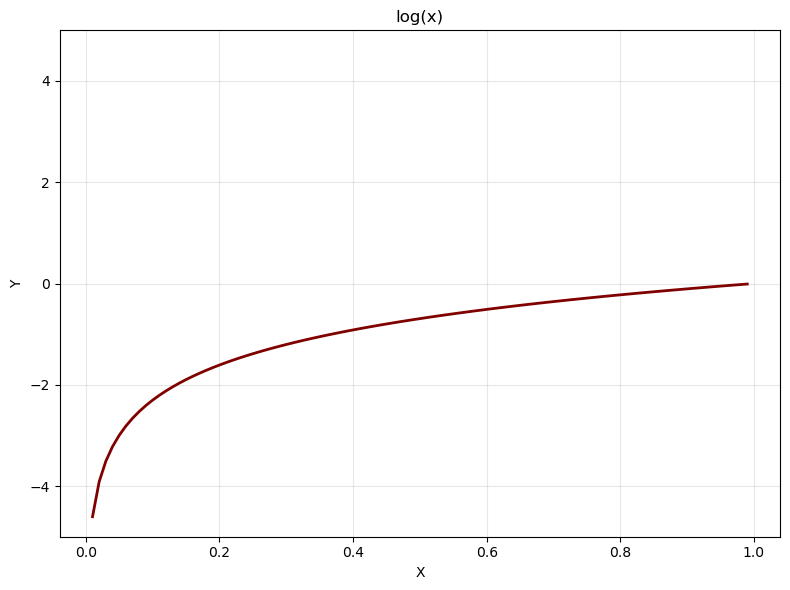

In [63]:
x = torch.arange(0, 1, 0.01)
y = torch.log(x)
_ = xlab.utils.plot_2d(x, y, y_range=[-5, 5], title="log(x)")

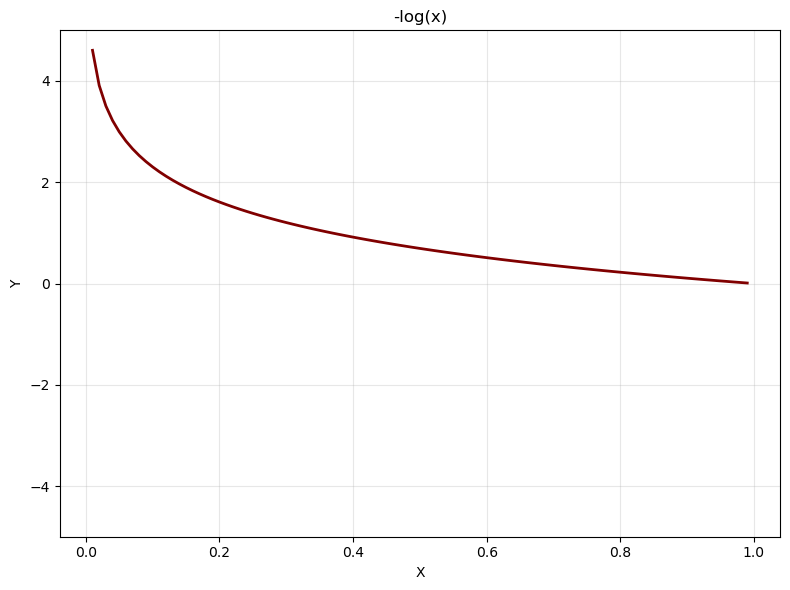

In [38]:
x = torch.arange(0, 1, 0.01)
y = torch.log(x)
_ = xlab.utils.plot_2d(x, -y, y_range=[-5, 5], title="-log(x)")